# Grad-Cam Implementation


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
import torch.optim as optim



In [30]:


# Define the PyTorch model (same as Keras model)
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 128)  # Adjust for input size (150x150)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

# Initialize model
model = CNN_Model()


In [33]:
# Define transforms (same as Keras ImageDataGenerator)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Load dataset (adjust paths)
train_dir = r"/content/drive/MyDrive/Machine Learning/Pattern Lab 1/data/train"
test_dir = r"/content/drive/MyDrive/Machine Learning/Pattern Lab 1/data/test"

# Load training and testing datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Class labels
class_names = train_dataset.classes  # Should be {'husky': 0, 'wolf': 1}
print(class_names)


['husky', 'wolf']


In [36]:
# Define loss function & optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for 2-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)
        labels = labels.view(-1, 1)  # Match output shape

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Save trained model
torch.save(model.state_dict(), "husky_wolf_model.pth")
print("Training complete! Model saved.")


Epoch 1/10, Loss: 0.8422, Accuracy: 0.5125
Epoch 2/10, Loss: 0.7876, Accuracy: 0.4875
Epoch 3/10, Loss: 0.6743, Accuracy: 0.5000
Epoch 4/10, Loss: 0.6209, Accuracy: 0.5000
Epoch 5/10, Loss: 0.5169, Accuracy: 0.6750
Epoch 6/10, Loss: 0.4081, Accuracy: 0.8125
Epoch 7/10, Loss: 0.2733, Accuracy: 0.8875
Epoch 8/10, Loss: 0.2625, Accuracy: 0.9375
Epoch 9/10, Loss: 0.2780, Accuracy: 0.9250
Epoch 10/10, Loss: 0.2831, Accuracy: 0.9000
Training complete! Model saved.


<ipython-input-57-0fcb3c1b2b2f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("husky_wolf_model.pth"))


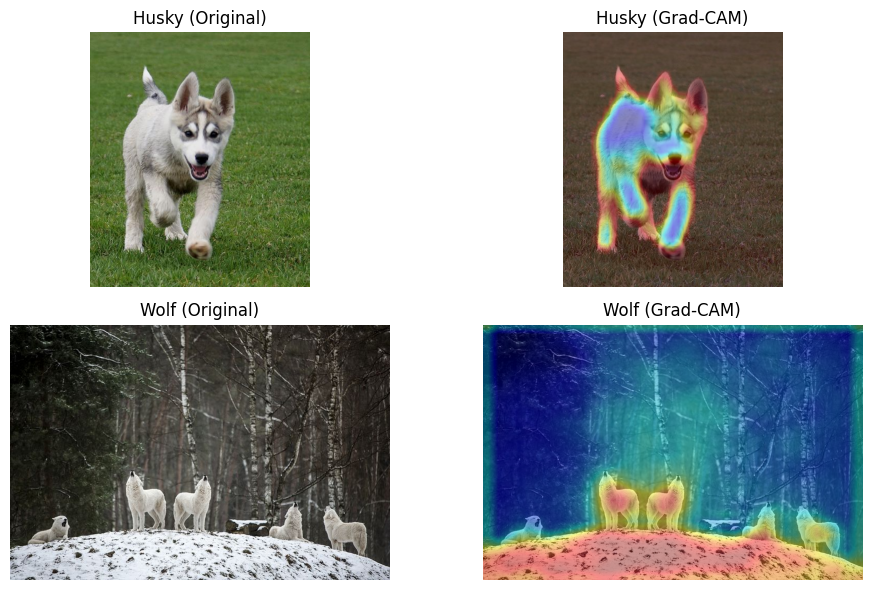

In [57]:
import numpy as np
import cv2
from PIL import Image

# Load trained model
model.load_state_dict(torch.load("husky_wolf_model.pth"))
model.eval()

# Select last conv layer for Grad-CAM
gradients = None
activations = None

def hook_function(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]  # Capture gradients

def forward_hook(module, input, output):
    global activations
    activations = output  # Save activations

# Hook into the last conv layer
target_layer = model.conv3
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(hook_function)

# Grad-CAM function
def generate_gradcam(image_tensor, class_idx):
    model.zero_grad()
    output = model(image_tensor)
    output[:, class_idx].backward()  # Compute gradients

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # Global avg pooling
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap

# Load a Husky & Wolf image
husky_img = Image.open("/content/drive/MyDrive/Machine Learning/Pattern Lab 1/data/test/husky/husky_40.jpeg").convert("RGB")
wolf_img = Image.open("/content/drive/MyDrive/Machine Learning/Pattern Lab 1/data/test/wolf/wolf_40.jpeg").convert("RGB")

# Transform image for model input
husky_tensor = transform(husky_img).unsqueeze(0)
wolf_tensor = transform(wolf_img).unsqueeze(0)

# Get predictions
husky_class_idx = torch.argmax(model(husky_tensor)).item()
wolf_class_idx = torch.argmax(model(wolf_tensor)).item()

# Generate heatmaps
husky_heatmap = generate_gradcam(husky_tensor, husky_class_idx)
wolf_heatmap = generate_gradcam(wolf_tensor, wolf_class_idx)

# Overlay Grad-CAM heatmap on image
def overlay_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))  # Match heatmap size to image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    img_cv = np.array(img)  # Convert PIL image to NumPy array
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV format)

    if img_cv.shape[:2] != heatmap.shape[:2]:
        print(f"Size mismatch! Resizing heatmap from {heatmap.shape} to {img_cv.shape[:2]}")
        heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))  # Resize correctly

    return cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

husky_overlay = overlay_heatmap(husky_img, husky_heatmap)
wolf_overlay = overlay_heatmap(wolf_img, wolf_heatmap)

# Display Results
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].imshow(husky_img)
axes[0, 0].set_title("Husky (Original)")
axes[0, 0].axis('off')

axes[0, 1].imshow(husky_overlay)
axes[0, 1].set_title("Husky (Grad-CAM)")
axes[0, 1].axis('off')

axes[1, 0].imshow(wolf_img)
axes[1, 0].set_title("Wolf (Original)")
axes[1, 0].axis('off')

axes[1, 1].imshow(wolf_overlay)
axes[1, 1].set_title("Wolf (Grad-CAM)")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
